Index(['timeStamp', 'timepoint', 'route', 'stop_id', 'block_id', 'trip_id',
       'block_abbr', 'vehicle', 'iteration', 'direction', 'longitude',
       'adherence', 'id', 'latitude'],
      dtype='object')
                 timeStamp                        timepoint  route  stop_id  \
0      2021-03-07 06:30:02         Clayton State University    193   213208   
1      2021-03-07 06:34:01               Kensington Station    121   900686   
2      2021-03-07 06:15:48  College Pk Station (South Loop)    196   166900   
3      2021-03-07 06:27:08       SRTA Riverdale Park & Ride     89   212139   
4      2021-03-07 06:29:08               East Point Station    193   146900   
...                    ...                              ...    ...      ...   
169603 2021-03-10 06:48:39  Joseph E Boone Bvd & Lowery Bvd     51   905158   
169604 2021-03-10 06:48:16    Alabama St & Broad St (5 Pts)    816   102258   
169605 2021-03-10 06:47:43                      VA Hospital     19   903581   
16

C:\Users\rapte\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[-2  0 -5 ... -3  0 -5]
Train on 50840 samples, validate on 5649 samples
Epoch 1/30
50840/50840 [==============================] - 9s 177us/step - loss: 15.4598 - val_loss: 13.0190
Epoch 2/30
50840/50840 [==============================] - 9s 172us/step - loss: 15.4074 - val_loss: 13.0291
Epoch 3/30
50840/50840 [==============================] - 9s 173us/step - loss: 15.3994 - val_loss: 13.0449
Epoch 4/30
50840/50840 [==============================] - 9s 171us/step - loss: 15.4009 - val_loss: 13.0690
Epoch 5/30
50840/50840 [==============================] - 9s 168us/step - loss: 15.3865 - val_loss: 13.0424
Epoch 6/30
50840/50840 [==============================] - 8s 166us/step - loss: 15.3746 - val_loss: 13.0259
Epoch 7/30
50840/50840 [==============================] - 8s 164us/step - loss: 15.3739 - val_loss: 13.0118
Epoch 8/30
50840/50840 [==============================] - 9s 173us/step - loss: 15.3717 - val_loss: 13.0137
Epoch 9/30
50840/50840 [==============================] - 9s 1

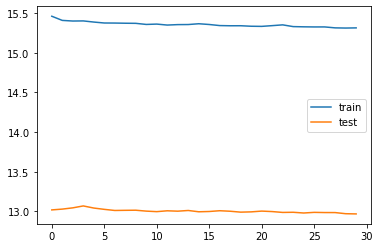

In [27]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 15 23:15:49 2021

@author: rapte
"""

import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing as prepro




data=pd.read_json("\\Users\\rapte\\git-AI\/Busdata.json",orient="values")



#Refactoring Column name
data.rename(columns = {'last_updated':"timeStamp"}, inplace = True)



#prepro
#Recategorizing Iteration as a integer for comparisons later

#initial Data manip
data["iteration"] = data["iteration"].astype(int)

data['timeStamp'] = pd.to_datetime(data['timeStamp'], format="%Y-%m-%d %H:%M:%S.%f")

print(data.columns)

#handling dups
data.drop_duplicates(subset=["timeStamp","vehicle"],inplace=True)

print(data)

#sorting and re indexing data
data.sort_values('timeStamp', inplace=True, ascending=True)
data=data.reset_index()


data["timeStamp"] = data["timeStamp"].dt.hour + data["timeStamp"].dt.minute/60


x = data[["timeStamp","vehicle","stop_id","route","direction","longitude","latitude"]]
y = data["adherence"]

print(x,y)


#transforming data ----------------------------------------------------------------------


#label encoding
label_encoder = []

for i in ["vehicle","stop_id","route","direction"]:
      labeler = prepro.LabelEncoder()
      x[i] = labeler.fit_transform(x[i])
      label_encoder.append(labeler)

print(x.size)


print(x)

#normalizing  -- do later see if improves things
#normalizer_list = []

#for i in ["longitude","latitude"]:
      







#----------------------------------------------------------------------------------------

#analysis


X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=5)

X_train, X_test = X_train.to_numpy().reshape(len(X_train),1,7), X_test.to_numpy().reshape(len(X_test),1,7)




#print(X_train.shape)


print(y_train.values)



model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1],X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')




history = model.fit(
    X_train, y_train.values, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();
plt.show()


In [28]:
y_pred = model.predict(X_test)

(14123,)
Mean absolute error = 2.3
Mean squared error = 13.64
Median absolute error = 1.79
Explain variance score = 0.01
R2 score = 0.01


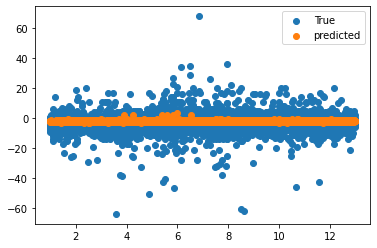

In [29]:
import sklearn.metrics as sm

X_graph = X_test.reshape(len(X_test),7)

print(X_test[:,0,0].shape)


plt.scatter(X_test[:,0,0],y_test,label="True")
plt.scatter(X_test[:,0,0],y_pred,label="predicted")

plt.legend()

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

In [30]:

filename = "lstm.h5"


model.save(filename)















#import pickle
#import dill
#import tempfile


'''
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()
'''




#dne
#pickle.dump(model, open(filename, 'wb'))

'\ndef make_keras_picklable():\n    def __getstate__(self):\n        model_str = ""\n        with tempfile.NamedTemporaryFile(suffix=\'.hdf5\', delete=False) as fd:\n            keras.models.save_model(self, fd.name, overwrite=True)\n            model_str = fd.read()\n        d = { \'model_str\': model_str }\n        return d\n\n    def __setstate__(self, state):\n        with tempfile.NamedTemporaryFile(suffix=\'.hdf5\', delete=False) as fd:\n            fd.write(state[\'model_str\'])\n            fd.flush()\n            model = keras.models.load_model(fd.name)\n        self.__dict__ = model.__dict__\n\n\n    cls = keras.models.Model\n    cls.__getstate__ = __getstate__\n    cls.__setstate__ = __setstate__\n\nmake_keras_picklable()\n'

(14123,)
Mean absolute error = 2.3
Mean squared error = 13.64
Median absolute error = 1.79
Explain variance score = 0.01
R2 score = 0.01


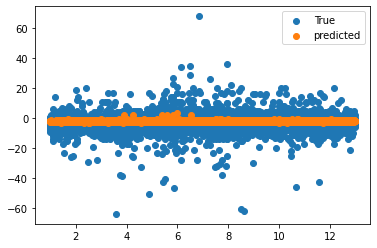

In [31]:
'''unpickler = pickle.Unpickler(open("lstm.sv",'rb'))
        # if file is not empty scores will be equal
        # to the value unpickled
loaded_m = unpickler.load()
'''

#loaded_m = pickle.load(open("lstm.sv",'rb'))

from keras.models import load_model

loaded_m = load_model("lstm.h5")



y_pred = loaded_m.predict(X_test)

X_graph = X_test.reshape(len(X_test),7)

print(X_test[:,0,0].shape)


plt.scatter(X_test[:,0,0],y_test,label="True")
plt.scatter(X_test[:,0,0],y_pred,label="predicted")

plt.legend()

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))